### Import

In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify

### with RWA

In [102]:
withRWA = True
Eq = 1
f = 0.1
def up1(val = 1):
    return Qobj(np.diag([val],1))
def down1(val = 1):
    return Qobj(np.diag([val],-1))

def Hq():
    return Eq/2 *sigmaz()
phase = 0
def Hf1():
    return f*sigmax()/2*np.sin(phase)
def Hf2():
    return f*sigmay()/2*np.cos(phase)
def Hf():
    return Hf1() + Hf2()
def collapse_list():
    return []
#Hf_time_coeff = "(0.5*(tanh((t-a)/st) - tanh((t-b)/st))*cos(w*t + phase1) + 0.5*(tanh((t-a2)/st) - tanh((t-b2)/st))*cos(w*t + phase2))"
Hf_time_coeff = "0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
Hf_time_coeff_func = lambdify({'a','b','t','st','w', 'phase'},Hf_time_coeff,'numpy')
#Hf_time_coeff = '1'
a = 2.5
b = a + 3.92
st = 0.001
phase1 = np.pi
phase2 = -np.pi/2
a2 = 70
b2 = 81.895
args = {'w':Eq, 'phase1':phase1, 'phase2':phase2,'a':a,'b':b,'st':st,'a2':a2,'b2':b2,'phase':phase}

maxtime = 11
points = 100
tlist = np.linspace(0,maxtime,points)
psi0 = (basis(2,0) + basis(2,1))/(2**0.5)
psi0 = basis(2,0)
def Hq_t():
    return [[Hf(),Hf_time_coeff]]


### without RWA

In [97]:
withRWA = False
Eq = 1
f = 0.1
def up1(val = 1):
    return Qobj(np.diag([val],1))
def down1(val = 1):
    return Qobj(np.diag([val],-1))

def Hq():
    return Eq/2 *sigmaz()
phase = 0
def Hf1():
    return f*sigmax()/2#*np.sin(phase)
def Hf2():
    return f*sigmay()/2#*np.cos(phase)
def Hf():
    return Hf1() + Hf2()
def collapse_list():
    return []
#Hf_time_coeff = "(0.5*(tanh((t-a)/st) - tanh((t-b)/st))*cos(w*t + phase1) + 0.5*(tanh((t-a2)/st) - tanh((t-b2)/st))*cos(w*t + phase2))"
Hf1_time_coeff = "(cos(phase) + cos(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
Hf2_time_coeff = "(-sin(phase) + sin(2*w*t + phase))*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
Hf1_time_coeff_func = lambdify({'a','b','t','st','w', 'phase'},Hf1_time_coeff,'numpy')
Hf2_time_coeff_func = lambdify({'a','b','t','st','w', 'phase'},Hf2_time_coeff,'numpy')
#Hf_time_coeff = '1'
a = 2.5
b = a + 3.92
st = 0.001
phase1 = np.pi
phase2 = -np.pi/2
a2 = 70
b2 = 81.895
args = {'w':Eq, 'phase':phase,'phase1':phase1, 'phase2':phase2,'a':a,'b':b,'st':st,'a2':a2,'b2':b2}
maxtime = 25
points = 100
tlist = np.linspace(0,maxtime,points)
psi0 = basis(2,0)
def Hq_t():
    return [[Hf1(),Hf1_time_coeff],[Hf2(),Hf2_time_coeff]]

#### extra funcs

In [82]:
expected = [sigmax(),sigmay(),sigmaz()]
psi0 = basis(2,0)
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [62]:
def visualize_output(output):
    fig, axes = plt.subplots(1,3, figsize=(13,5), sharey=True)
    axes[0].set_title('Che-to tam s qubitom');
    labels = ['sigmax','sigmay','sigmaz']
    for idx, ax in enumerate(axes):
        ax.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.2,1.2)
        ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
        ax.set_xlabel('Time')
    axes[0].set_ylabel('Occupation probability')

def vis_out(output, title = 'Che-to tam s qubitom'):
    fig, ax = plt.subplots(1,1, figsize=(6,5), sharey=True, dpi =600)
    ax.set_title(title);
    labels = ['$\sigma_x(t)$','$\sigma_y(t)$','$\sigma_z(t)$']
    for idx, op in enumerate(output.expect):
        ax.plot(tlist, op, label=(labels[idx]), linewidth = 3 )
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.2,1.2)
        
    if withRWA:
        pulse = -0.5+f/Eq*Hf_time_coeff_func(a=args['a'],b=args['b'],st=args['st'],w=args['w'],phase=args['phase'],t=tlist)
        ax.plot(tlist, pulse, label = "$h_{RWA}(t)$")

    else:
        pulse1 = -0.5+f/Eq*Hf1_time_coeff_func(a=args['a'],b=args['b'],st=args['st'],w=args['w'],phase=args['phase'],t=tlist)
        pulse2 = -0.5+f/Eq*Hf2_time_coeff_func(a=args['a'],b=args['b'],st=args['st'],w=args['w'],phase=args['phase'],t=tlist)
        ax.plot(tlist, pulse1, label = "$h1_{noRWA}(t)$", linewidth = 1.5)
        ax.plot(tlist, pulse2, label = "$h2_{noRWA}(t)$", linewidth = 1.5)
    
    ax.legend(bbox_to_anchor = [1,1],loc = "upper right")
    ax.set_xlabel('Time')
    
    ax.set_ylabel('Occupation probability')

## X-pulse 

In [98]:
phase = 0

## Y-pulse 

In [73]:
phase = -np.pi/2

## Z-pulse

In [103]:
def Hqz_t():
    return [[f*sigmaz()/2,Hf_time_coeff]]
Hf_time_coeff = "0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
psi0z = (basis(2,0)+basis(2,1))/(2**0.5)
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hqz_t(), psi0z, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hqz_t(), psi0z, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

### $\frac{\pi}{2}$  pulse

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.04s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.05s
0.0


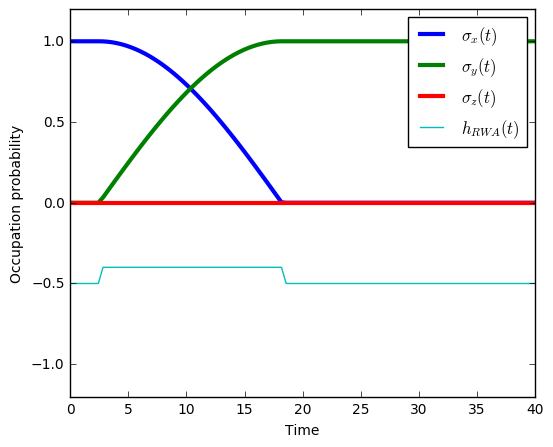

In [104]:
args['b'] = args['a'] + np.pi/f/2
maxtime = 40
tlist = np.linspace(0,maxtime,points)
output = solve(expected)
print(output.expect[2][-1])
vis_out(output, "")#r"$\frac{\pi}{2}$ pulse"

### $\pi$  pulse

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.04s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.04s. Est. time left: 00:00:00:00
Total run time:   0.05s
0.0


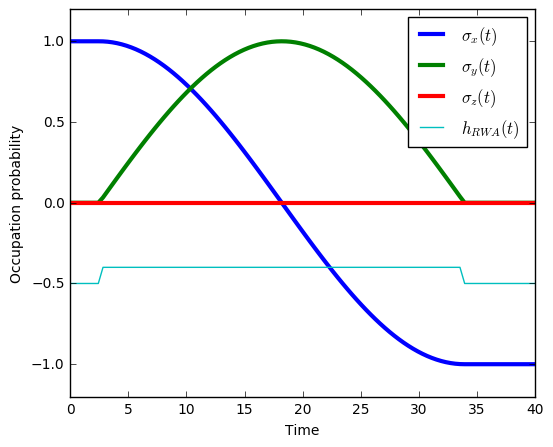

In [105]:
args['b'] = args['a'] + np.pi/f
maxtime = 40
tlist = np.linspace(0,maxtime,points)
output = solve(expected)
print(output.expect[2][-1])
vis_out(output, "")